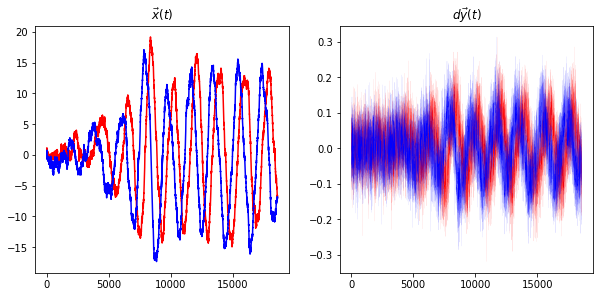

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from tqdm import tqdm
from misc import *
import tensorflow as tf
%load_ext autoreload
%autoreload 2


means = np.load("data/means.npy").astype(np.float32) ### this is \textbf{q}(t)
covs = np.load("data/covs.npy").astype(np.float32) ## this is the \Sigma(t)
xicovs = np.load("data/xicovs.npy").astype(np.float32) ## this is the \Chi(\Sigma) (evolution)
signals = np.load("data/signals.npy").astype(np.float32) ##this is the dy's

A = np.load("data/A.npy").astype(np.float32)
dt = np.load("data/dt.npy")[0]
C = np.load("data/C.npy").astype(np.float32)
D = np.load("data/D.npy").astype(np.float32)

coeffs = [C, A, D , dt]

plt.figure(figsize=(10,10))
plt.subplot(221)
plt.title(r'$\vec{x}(t)$')
for ind, c in enumerate(["red","blue"]):
    plt.plot(np.array(means)[:,ind], color=c)
plt.subplot(222)
plt.title(r'$d\vec{y}(t)$')
for ind, c in enumerate(["red","blue"]):
    plt.plot(np.array(signals)[:,ind], color=c, linewidth=0.05)


In [2]:
def sliced_dataset(t):
    tfsignals = tf.convert_to_tensor(signals)[:t] ## this are dy's
    tfxicovs = tf.convert_to_tensor(xicovs)[:-1][:t] ### since we get (\mu_t, \Sigma_t) ---> Measurement ( = signal) ---> (\mu_{t+1}, \Sigma_{t+1})
    return (tfxicovs[tf.newaxis,:,:,:], tfsignals[tf.newaxis,:,:])

In [11]:
from RNN_models import *

model = GaussianRecuModel(coeffs)
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.1))
model(sliced_dataset(1))
initial_A = model.trainable_variables
initial_A

[<tf.Variable 'gaussian_recu_model_5/rnn_5/stacked_rnn_cells_5/gaussian_dynamics__recurrent_cell_5/kernel:0' shape=(2, 2) dtype=float32, numpy=
 array([[ 0.04031006, -0.02438934],
        [-0.04981655, -0.03314461]], dtype=float32)>]

In [12]:
for time_slice in tqdm(range(10,len(signals),1000)):
    inputs = sliced_dataset(time_slice)
    model.fit(x=inputs, y=inputs[1][tf.newaxis,:,:], epochs=1, verbose=0)

100%|██████████| 19/19 [00:38<00:00,  2.00s/it]


In [13]:
model.trainable_variables

[<tf.Variable 'gaussian_recu_model_5/rnn_5/stacked_rnn_cells_5/gaussian_dynamics__recurrent_cell_5/kernel:0' shape=(2, 2) dtype=float32, numpy=
 array([[ 0.05193511,  1.1521766 ],
        [-1.145133  , -0.0095314 ]], dtype=float32)>]

In [15]:
predictions = model.recurrent_layer(sliced_dataset(len(signals)), initial_state=model.initial_state)
tfmeans = tf.convert_to_tensor(means.astype(np.float32))
Cxdt=tf.einsum('ij,kj->ki',model.C, tfmeans)*model.dt

Text(0.5, 0, 'time')

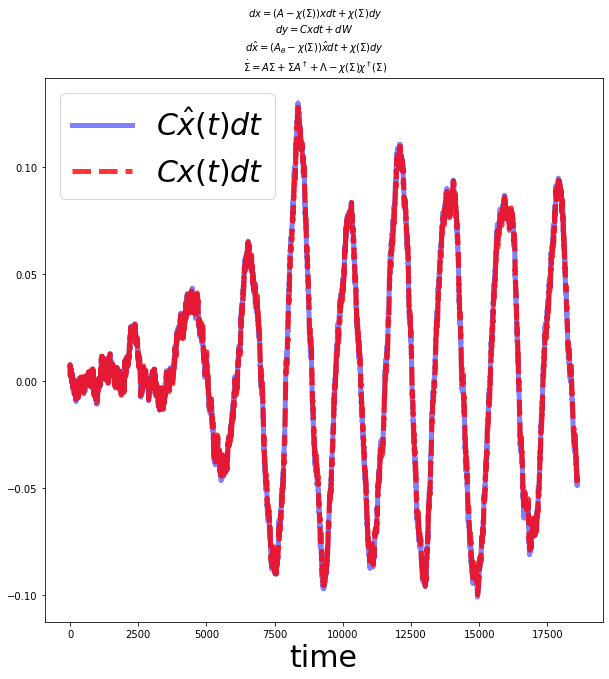

In [16]:
plt.figure(figsize=(10,10))

#plt.title("Learning stochastic time-series")
plt.suptitle(r'$ dx = (A - \chi(\Sigma))x dt + \chi(\Sigma) dy$' +
             "\n" r'$dy =  C x dt + dW$'+ "\n" +
             r'$ d\hat{x} = (A_\theta - \chi(\Sigma))\hat{x} dt + \chi(\Sigma) dy$'
            + "\n" + r'$\dot{\Sigma} = A \Sigma + \Sigma A^\dagger + \Lambda - \chi(\Sigma) \chi^\dagger(\Sigma)$', size=10)
plt.plot(predictions[0][:,0], color="blue", alpha=0.5, linewidth=5, label=r'$C \hat{x}(t) dt$')
plt.plot(Cxdt[:,0],'--', color="red", alpha=0.8,label=r'$C x(t) dt$', linewidth=5)
plt.legend(prop={"size":30})
plt.xlabel("time", size=30)